In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sz
import pandas as pd
import pandas as pd
from scapy.all import rdpcap
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap
import chardet
import binascii



In [78]:
df_all=pd.read_csv(r"C:\Users\Philipp\OneDrive - UT Cloud\Data_literacy_mensa\Mensa_data_combined\Friday120124.csv")
df_all

,frame.number,frame.time,wlan.sa,wlan.da,_ws.col.protocol,frame.len,wlan.ssid
0,1,"Jan 11, 2024 11:01:04.553359000 Mitteleuropäis...",00:f6:63:81:c8:6f,ff:ff:ff:ff:ff:ff,802.11,346,656475726f616d
1,2,"Jan 11, 2024 11:01:04.565399000 Mitteleuropäis...",00:f6:63:81:c8:6b,ff:ff:ff:ff:ff:ff,802.11,305,55546775657374
2,3,"Jan 11, 2024 11:01:04.602223000 Mitteleuropäis...",00:f6:63:81:c8:6e,ff:ff:ff:ff:ff:ff,802.11,293,4775657374
3,4,"Jan 11, 2024 11:01:04.607003000 Mitteleuropäis...",d4:ca:6d:e1:ab:de,78:4f:43:50:d3:7e,802.11,162,NaN
4,5,"Jan 11, 2024 11:01:04.608718000 Mitteleuropäis...",d4:ca:6d:e1:ab:de,78:4f:43:50:d3:7e,802.11,162,NaN
...,...,...,...,...,...,...,...
9703254,7875,"Jan 11, 2024 14:04:29.974432000 Mitteleuropäis...",NaN,NaN,802.11,57,NaN
9703255,7876,"Jan 11, 2024 14:04:29.974560000 Mitteleuropäis...",NaN,NaN,802.11,45,NaN
9703256,7877,"Jan 11, 2024 14:04:29.974619000 Mitteleuropäis...",NaN,NaN,802.11,39,NaN
9703257,7878,"Jan 11, 2024 14:04:29.974679000 Mitteleuropäis...",NaN,NaN,802.11,39,NaN


exploring data based on SSID's

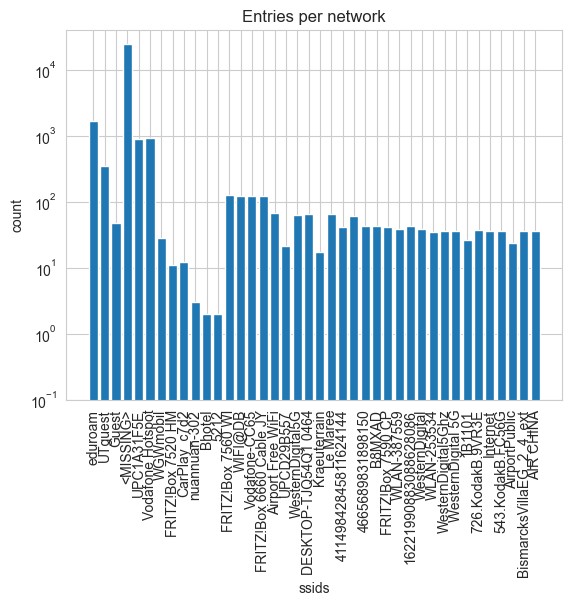

In [79]:
ssids_counts = df_all["wlan.ssid"].value_counts().reset_index()
ssids_counts.columns = ["wlan.ssid", "count"]

# Step 2: Group by WLAN SSID and count the number of unique entries in wlan.sa
unique_sa_counts = df_all.groupby("wlan.ssid")["wlan.sa"].nunique().reset_index()
unique_sa_counts.columns = ["wlan.ssid", "unique_sa_count"]

# Step 3: Merge the two DataFrames on "wlan.ssid"
result = pd.merge(ssids_counts, unique_sa_counts, on="wlan.ssid")
result = result.to_numpy()
# Conversion from hexadecimal to "human"
def hex_to_str(hex_str):
    if len(hex_str) % 2 != 0:
        return hex_str
    bytes_obj = binascii.unhexlify(hex_str)
    return bytes_obj.decode('latin-1')


vec_func = np.vectorize(hex_to_str)

result[:,0] = vec_func(result[:,0])
# This displays the first 40 ssids and their number of entries

names = result[:40, 0]
value = result[:40, 2].astype(int)

plt.bar(names, value)
plt.xlabel("ssids")
plt.xticks(rotation='vertical')
plt.ylabel("count")
plt.yscale("log")
plt.ylim(bottom=0.1)
plt.title("Entries per network")
plt.show()

we get the users on just one SSID network

In [80]:
eduroam_ssid = "656475726f616d"
# The ^ tell the regular expression, that it start with the pattern that follows
cisco_pattern = "^" + "00:f6:63:"

df_dpa = df_all.loc[df_all['_ws.col.protocol'] == "EAP"]

# Authentication with all cisco devices
df_dpa_cisco = df_dpa.loc[df_dpa["wlan.sa"].str.match(cisco_pattern)]

# Authenticated mac addresses as a list
dpa_cisco_list = df_dpa_cisco["wlan.da"].unique().tolist()

# All data filterd for eduroam, UTGuest and Guest
df = df_all.loc[(df_all["wlan.ssid"] == eduroam_ssid)|(df_all["wlan.ssid"] == "55546775657374" )|( df_all["wlan.ssid"] =="4775657374")]

# all unique mac addresses with the ssids
all_sources = df["wlan.sa"].unique().tolist()

# Combination of mac addresses of the ssids and EPA
combined_macs = list(set(all_sources + dpa_cisco_list))
print(f"Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco['wlan.da'].nunique()}")

# All entries that use the resulting mac addresses
df = df_all.loc[df_all['wlan.sa'].isin(combined_macs)]

Number of unqiue mac addresses verfied by cisco: 757


converting the time format to a processable one and dropping all na values in the source set to further clean the data

In [81]:
df["frame.time"] = df["frame.time"].str.replace(r':\d+\.\d+', '', regex=True)
df['frame.time'] = df['frame.time'].str.replace('Mitteleuropäische Zeit', 'CET')
df['date-time'] = pd.to_datetime(df['frame.time'], format='%b %d, %Y %H:%M %Z', errors='coerce')
df['hour:minute'] = df['date-time'].dt.strftime('%H:%M')
df.dropna(subset=["wlan.sa"])
df['wlan.bssid'].value_counts().sort_index()

C:\Users\Philipp\AppData\Local\Temp\ipykernel_7316\3516351953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["frame.time"] = df["frame.time"].str.replace(r':\d+\.\d+', '', regex=True)
C:\Users\Philipp\AppData\Local\Temp\ipykernel_7316\3516351953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frame.time'] = df['frame.time'].str.replace('Mitteleuropäische Zeit', 'CET')
C:\Users\Philipp\AppData\Local\Temp\ipykernel_7316\3516351953.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

KeyError: 'wlan.bssid'

filtering data for mac unique MAC's first and last appreances.

In [ ]:
df_first = df.drop_duplicates(subset='wlan.sa', keep='first')
df_last = df.drop_duplicates(subset='wlan.sa', keep='last')
print(df_first["wlan.sa"].nunique())
print(df_last["wlan.sa"].nunique())
f=plt.plot(df_first["hour:minute"].value_counts().sort_index())
max_ent=max(df_first["hour:minute"].value_counts().sort_index())
plt.title("max of people who entered the mensa in a minute ={x}".format(x=max_ent))
plt.legend()

In [ ]:
max_ext=max(df_last["hour:minute"].value_counts().sort_index())
l=plt.plot(df_last["hour:minute"].value_counts().sort_index())
plt.title("max of people who exited the mensa in a minute ={x}".format(x=max_ext))
plt.legend()

we check how many mac addresses were seen for the first and the last time in the network per minute.

In [ ]:
per_min_new=pd.DataFrame(df_first["hour:minute"].value_counts().sort_index())
plt.plot(per_min_new['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('New MAC id seen in the network Count/ minute')

In [ ]:
per_min_last=pd.DataFrame(df_last["hour:minute"].value_counts().sort_index())
plt.plot(per_min_last['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('last seen unique MAC id seen in the network Count/ minute')

how many mac addresses were seen for the first and the last time in the network at 5 min time intervals

In [ ]:
_5min_new = pd.DataFrame({'hour:minute':per_min_new.index.tolist(),'count': per_min_new["count"]})
_5min_new['hour:minute'] = pd.to_datetime(_5min_new['hour:minute'], format='%H:%M')
_5min_new['hour:minute'].dt.strftime('%H:%M')
_5min_new.set_index('hour:minute',inplace=True)
_5min_new_ = _5min_new.resample('5T').sum()
#_5min_new_
plt.plot(_5min_new_['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('first seen Count / 5 min')

In [ ]:
_5min_last = pd.DataFrame({'hour:minute':per_min_last.index.tolist(),'count': per_min_last["count"]})
_5min_last['hour:minute'] = pd.to_datetime(_5min_last['hour:minute'], format="%H:%M")
_5min_last.set_index('hour:minute', inplace=True)
last_per5min_ = _5min_last.resample('5T').sum()
#last_per5min_
plt.plot(last_per5min_['count'], marker='o')
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.title('last seen Count / 5 min')

total number of users seen during a day based on MAC id's number of people present in the mensa at a particular time

In [ ]:
np.cumsum(_5min_new_['count'])
plt.plot(np.cumsum(_5min_new_['count']),label="cumsum of new users entered every 5 min")
plt.plot(np.cumsum(last_per5min_['count']),label="cumsum of users exited every 5 min")
plt.plot(np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']), marker='*',label="cumilative sum of users 5 min")
plt.title("total users in a day")
plt.legend()

lookinng at the difference in order to estimate the que forming due to the entering of new people in the network

In [ ]:
cu=(np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']))
cu.max()


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(_5min_new_['count'], marker='o',label="new users entered every 5 min\n(new people entring)")
plt.plot(last_per5min_['count'], marker='*',label="users exitied every 5 min\n(people exiting)")
plt.plot((_5min_new_['count']-last_per5min_['count']),color="black", linestyle=":",label="difference between new and exited users\n(people in line)")
plt.plot(((np.cumsum(_5min_new_['count'])-np.cumsum(last_per5min_['count']))), marker='v',label="cumilative sum of users 5 min\n(people present in mensa at the time)")
plt.xlabel('Time (hour:minute)')
plt.ylabel('Count')
plt.suptitle('Last seen Count first seen count and difference')
#plt.title("(the value of orange and blue lines are divided by 10 to make it comparable to difference)", fontsize="small")
plt.legend(loc="upper left")

difference between first and last seen time

In [ ]:
from tqdm import tqdm
# df_first["hour:minute"] = pd.to_datetime(df_first["hour:minute"])
# df_last["hour:minute"] = pd.to_datetime(df_last["hour:minute"])
diff=[]

for i in tqdm(df_first["wlan.sa"], total=len(df_first)):
    index_first = df_first.loc[df_first["wlan.sa"] == i]["hour:minute"].tolist()[0]
    first_hour, first_minute = map(int, index_first.split(':'))
    first_time = first_hour * 60 + first_minute
    #index_first = index_first.dt.minute
    index_last_source = df_last.loc[df_last["wlan.sa"] == i]["hour:minute"].tolist()[0]
    last_hour_source, last_minute_source = map(int, index_last_source.split(':'))
    last_time_source = last_hour_source * 60 + last_minute_source
    
    df_last_dst = df.drop_duplicates(subset='wlan.da', keep='last')
    index_last_dst = df_last_dst.loc[df_last_dst["wlan.da"] == i]["hour:minute"]
    if len(index_last_dst) != 0:
        index_last_dst = index_last_dst.tolist()[0]
        last_hour_dst, last_minute_dst = map(int, index_last_dst.split(':'))
        last_time_dst = last_hour_dst * 60 + last_minute_dst
    else:
        last_time_dst = 0
    
    last_time = max(last_time_source, last_time_dst)
    #index_last = index_last.dt.minute

    # Calculate the time difference between corresponding rows in minutes
    time_diff = (last_time - first_time)
    # Append the wlan.sa value and time difference in minutes to the result list
    diff.append({"wlan.sa": i, "time_difference": time_diff})
        
diff_df=pd.DataFrame(diff)
diff_df.drop_duplicates(subset='wlan.sa', keep='first')
#print(time_diff.sort_index())


In [ ]:
time_d=diff_df["time_difference"].value_counts().sort_index()
print((diff_df.loc[diff_df['time_difference']!=0]).count())

see how long a person stays in the mensa network

below is the histogram along with the violinplot showing how the average time spent at mensa is distributed

In [ ]:
plt.hist(time_d.index, weights=time_d, bins=180, alpha=0.7)
#plt.boxplot(time_d.sort_index(), vert=False, showmeans=True)
plt.xlabel("Time spent at mensa in minutes")
plt.ylabel("Count of people \n(divided by 100 to scale with deviation of violin)")
plt.yticks(np.arange(0,2 , step=.1),labels=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2))
plt.show()

In [ ]:
'''    diff_df["time_difference"].sort_values( ascending=False)
    diff_df.drop_duplicates(subset='wlan.sa', keep='first')
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,)
    ax1.hist(time_diff.index, weights=time_diff, bins=20)
    ax2.violinplot(time_diff.index, showmeans=True)
    fig.text(0.5, 0.04, 'X-axis Label', ha='center')
    fig.text(0.04, 0.5, 'Y-axis Label', va='center', rotation='vertical')
    fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()'''